In [1]:
import pandas as pd
import numpy as np
import cPickle
import sys
sys.path.insert(0, '../../preprocess')
import vectorizer
aspects = ['population', 'intervention', 'outcome']
aspects = [a[0].upper() for a in aspects]

import keras.backend as K

Using TensorFlow backend.


[]


In [11]:
df = pd.read_csv('../data/files/test_cohen_dedup.csv')

nb_studies = len(df)
H = np.zeros((nb_studies, nb_studies))

cdnos = list(set(df.cdno))
for i in range(nb_studies) :
    H[i, df[df['cdno'] == df['cdno'][i]].index] = 1

H[np.arange(nb_studies), np.arange(nb_studies)] = 0

In [12]:
cohenvec = cPickle.load(open('../data/vectorizers/cohendata_dedup_5000.p', 'rb'))

In [13]:
from keras.models import load_model
model = load_model('../store/weights/single_setup/SatDec216:57:342017final1/loss.h5', 
                   custom_objects={'contrastive_loss' : lambda a,b : a, '<lambda>' : lambda a, b : a})
#results_folder = '../store/results/single_message_ThuOct1919:10:492017/'

In [14]:
model_aspect = {}
for aspect in aspects :
    model_aspect[aspect] = K.function(model.get_layer('pool_'+aspect).inputs + [K.learning_phase()], 
                          [model.get_layer('pool_'+aspect).outputs[0]])

In [15]:
X_cohen = cohenvec.X

In [16]:
embedds_dic = {}
for aspect in aspects :
    embedds_dic[aspect] = model_aspect[aspect]([X_cohen, 0])[0]

In [17]:
from sklearn.preprocessing import normalize
embedds_dic = {input : normalize(x, 'l2') for input, x in embedds_dic.items()}

In [18]:
embedds = np.concatenate(embedds_dic.values(), axis=1)
embedds.shape

(1767, 600)

In [19]:
scores = np.dot(embedds, embedds.T)
scores[np.arange(nb_studies), np.arange(nb_studies)] = -1000

In [20]:
from sklearn.metrics import roc_auc_score
aucs = [0] * nb_studies
for i in range(nb_studies) :
    aucs[i] = roc_auc_score(H[i], scores[i])
print np.mean(aucs)
rocs = {}
for cd in cdnos :
    idxs = df[df.cdno == cd].index
    rocs[cd] = np.mean(np.array(aucs)[idxs])
print pd.Series(rocs)

0.883981200198
ACEInhibitors_processed              0.882339
ADHD_processed                       0.896514
Antihistamines_processed             0.868549
AtypicalAntipsychotics_processed     0.963825
BetaBlockers_processed               0.762162
CalciumChannelBlockers_processed     0.740295
Estrogens_processed                  0.962365
NSAIDS_processed                     0.903352
Opiods_processed                     0.926963
OralHypoglycemics_processed          0.941248
ProtonPumpInhibitors_processed       0.929369
SkeletalMuscleRelaxants_processed    0.689777
Statins_processed                    0.824142
Triptans_processed                   0.976654
dtype: float64


In [16]:
for aspect in aspects :
    scores_a = np.dot(embedds_dic[aspect], embedds_dic[aspect].T)
    scores_a[np.arange(nb_studies), np.arange(nb_studies)] = -1000
    from sklearn.metrics import roc_auc_score
    aucs = [0] * nb_studies
    for i in range(nb_studies) :
        aucs[i] = roc_auc_score(H[i], scores_a[i])
    print np.mean(aucs)
    rocs = {}
    for cd in cdnos :
        idxs = df[df.cdno == cd].index
        rocs[cd] = np.mean(np.array(aucs)[idxs])
    print aspect
    print pd.Series(rocs)

0.844274922796
P
ACEInhibitors_processed              0.846041
ADHD_processed                       0.830287
Antihistamines_processed             0.842192
AtypicalAntipsychotics_processed     0.912392
BetaBlockers_processed               0.730467
CalciumChannelBlockers_processed     0.732771
Estrogens_processed                  0.963898
NSAIDS_processed                     0.920415
Opiods_processed                     0.840637
OralHypoglycemics_processed          0.906668
ProtonPumpInhibitors_processed       0.887165
SkeletalMuscleRelaxants_processed    0.581941
Statins_processed                    0.750780
Triptans_processed                   0.924135
dtype: float64
0.793020970065
I
ACEInhibitors_processed              0.831372
ADHD_processed                       0.695369
Antihistamines_processed             0.724691
AtypicalAntipsychotics_processed     0.958679
BetaBlockers_processed               0.771279
CalciumChannelBlockers_processed     0.667199
Estrogens_processed            

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [22]:
tsne = TSNE(n_components=2).fit_transform(embedds)

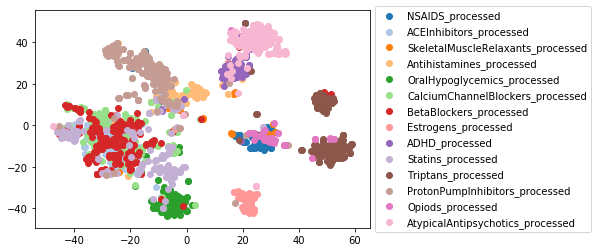

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=cm.Vega20.colors)
labels = np.array([0] * nb_studies)
for i, cd in enumerate(cdnos) :
    idxs = df[df.cdno == cd].index
    plt.scatter(tsne[idxs, 0], tsne[idxs, 1], label=cd, cmap=cm.jet)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
cm.Vega20.colors

In [1]:
dic = eval("{'NSAIDS_processed': 0.90095649316291104, 'ACEInhibitors_processed': 0.88109428226428987, 'SkeletalMuscleRelaxants_processed': 0.68548706173275642, 'Triptans_processed': 0.97677233375507277, 'OralHypoglycemics_processed': 0.93704288227674348, 'CalciumChannelBlockers_processed': 0.7370783282300909, 'BetaBlockers_processed': 0.76061816163099849, 'Estrogens_processed': 0.96165077526024256, 'ADHD_processed': 0.89555840595970215, 'Statins_processed': 0.82049843835901592, 'Antihistamines_processed': 0.86736208761693878, 'ProtonPumpInhibitors_processed': 0.92297834548109192, 'Opiods_processed': 0.92120976739587879, 'AtypicalAntipsychotics_processed': 0.96305959423101983}")
import pandas as pd
pd.Series(dic)

ACEInhibitors_processed              0.881094
ADHD_processed                       0.895558
Antihistamines_processed             0.867362
AtypicalAntipsychotics_processed     0.963060
BetaBlockers_processed               0.760618
CalciumChannelBlockers_processed     0.737078
Estrogens_processed                  0.961651
NSAIDS_processed                     0.900956
Opiods_processed                     0.921210
OralHypoglycemics_processed          0.937043
ProtonPumpInhibitors_processed       0.922978
SkeletalMuscleRelaxants_processed    0.685487
Statins_processed                    0.820498
Triptans_processed                   0.976772
dtype: float64

In [1]:
import matplotlib.cm as cm

In [2]:
cm.Dark2.colors

((0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4))